# Prophet Exercise
March 1st 2022

In [1]:
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import os
print(os.getcwd())
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series_forecasting/time_series_analysis/week_3/3_fb_prophet


In [2]:
# Custom functions:
import src.colorsetup

# 1) Predicting C02

In [3]:
data_path= 'course_data/'
co2= pd.read_csv(data_path+'co2-ppm-mauna-loa-19651980.csv',
                 header= 0, names= ['idx', 'co2'],
                 engine= 'python', skipfooter= 2)
co2 = co2.drop('idx', 1)

# recast co2 col to float
co2['co2'] = pd.to_numeric(co2['co2'])
co2.drop(labels=0, inplace=True)

# set index
index = pd.date_range('1/1/1965', periods=191, freq='M')
co2.index = index
co2.head()

,co2
1965-01-31,320.36
1965-02-28,320.82
1965-03-31,322.06
1965-04-30,322.17
1965-05-31,321.95


In [4]:
# Prophet needs as input: ds => date & y => for time-series data
co2['ds']= co2.index
co2.rename(columns= {'co2':'y'}, inplace= True)
co2.head()

,y,ds
1965-01-31,320.36,1965-01-31
1965-02-28,320.82,1965-02-28
1965-03-31,322.06,1965-03-31
1965-04-30,322.17,1965-04-30
1965-05-31,321.95,1965-05-31


In [ ]:
model= Prophet()
model.fit(co2)

In [6]:
# 10 years into the future
future= model.make_future_dataframe(periods= 120, freq= 'M', include_history= True)
display(co2.tail())
future.tail()

,y,ds
1980-07-31,337.19,1980-07-31
1980-08-31,335.49,1980-08-31
1980-09-30,336.63,1980-09-30
1980-10-31,337.74,1980-10-31
1980-11-30,338.36,1980-11-30


,ds
306,1990-07-31
307,1990-08-31
308,1990-09-30
309,1990-10-31
310,1990-11-30


In [7]:
# Populate forecast:
forecast= model.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat
306,1990-07-31,353.812057
307,1990-08-31,352.158724
308,1990-09-30,352.054514
309,1990-10-31,353.339060
310,1990-11-30,354.532478


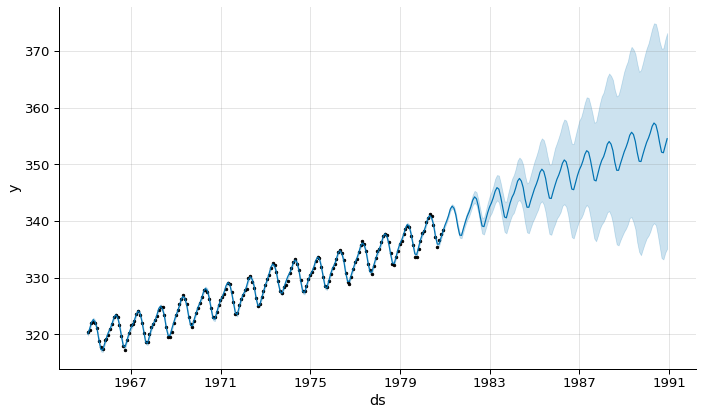

In [8]:
forecaset_plot= model.plot(forecast)

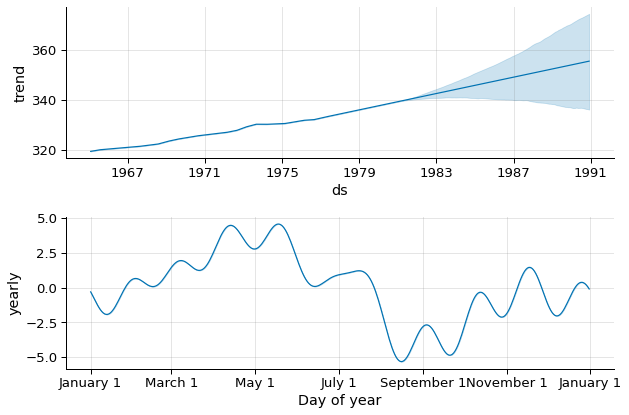

In [9]:
forecast_components= model.plot_components(forecast)

### Additional modifications

In [10]:
# seasonality_prior_scale: 
    # Parameter modulating the strength of the seasonality model. 
    # Larger values allow the model to fit larger seasonal fluctuations.
    # Whereas smaller values dampen (desalentar) the seasonality. 
    # Can be specified for individual seasonalities using add_seasonality.

changepoint_prior_scale=0.05 # Default value
seasonality_prior_scale= 0.00001 # Default is= 10.0
growth= 'logistic' # Default= linear
# When you're working with logistic growth you need to add a cap i.e. we limit our theoretical growth
co2['cap'] = 350
co2.head()

,y,ds,cap
1965-01-31,320.36,1965-01-31,350
1965-02-28,320.82,1965-02-28,350
1965-03-31,322.06,1965-03-31,350
1965-04-30,322.17,1965-04-30,350
1965-05-31,321.95,1965-05-31,350


In [11]:
m= Prophet(growth= growth, seasonality_prior_scale= seasonality_prior_scale, changepoint_prior_scale= changepoint_prior_scale)
m.fit(co2)
# We need to add cap to future data
future= m.make_future_dataframe(periods= 120, freq= 'M', include_history= True) # 10 years
future['cap']= 350
forecast= m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.14308
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       869.623   0.000524219       3322.93           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       870.457   2.08849e-08       81.5279   1.238e-10       0.001      265  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


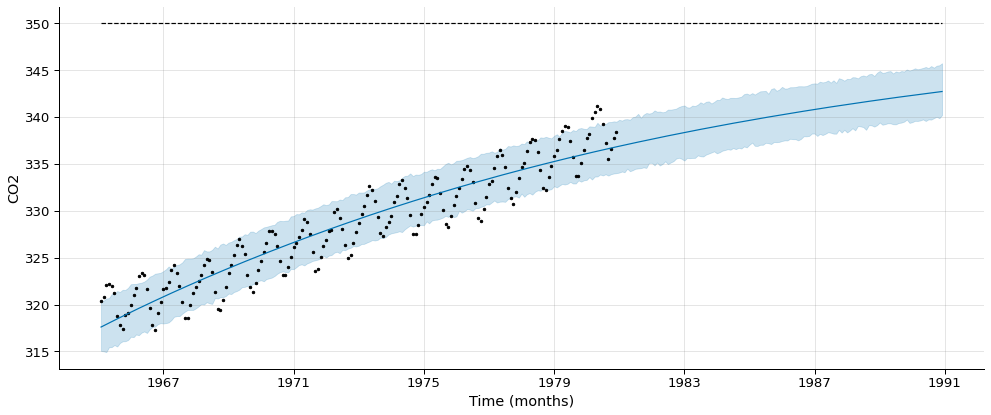

In [19]:
forecast_plot= m.plot(forecast, figsize= (14,6), xlabel= "Time (months)", ylabel= "CO2")

# 2) PM: Beijing dataset

In [20]:
df_beijing= pd.read_csv(data_path+'FiveCitiesPM/Beijing.csv')
df_beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [21]:
# Due date type we need to create our own ds
def make_date(row):
    return datetime(year= row['year'], month= row['month'], day= row['day'], hour= row['hour'])

In [22]:
df_beijing['date']= df_beijing.apply(make_date, axis= 1)
# df_beijing.head()
df_beijing.set_index('date', inplace= True)
df_beijing['ds']= df_beijing.index
# Take only required fileds
df_beijing.head()
df= df_beijing[['ds', 'PM_Dongsi']].rename(columns= {'PM_Dongsi': 'y'})
df.tail()

,ds,y
date,,
2015-12-31 19:00:00,2015-12-31 19:00:00,140.0
2015-12-31 20:00:00,2015-12-31 20:00:00,157.0
2015-12-31 21:00:00,2015-12-31 21:00:00,171.0
2015-12-31 22:00:00,2015-12-31 22:00:00,204.0
2015-12-31 23:00:00,2015-12-31 23:00:00,NaN


In [23]:
# Train and test sets:
df_train = df.loc['2015-11']
df_test = df.loc['2015-12':'2015-12-15']
print("Train shape: {}".format(df_train.shape))
display(df_train.tail())
print('')
print('Test shape: {}'.format(df_test.shape))
display(df_test.tail())

Train shape: (720, 2)


,ds,y
date,,
2015-11-30 19:00:00,2015-11-30 19:00:00,685.0
2015-11-30 20:00:00,2015-11-30 20:00:00,685.0
2015-11-30 21:00:00,2015-11-30 21:00:00,638.0
2015-11-30 22:00:00,2015-11-30 22:00:00,548.0
2015-11-30 23:00:00,2015-11-30 23:00:00,490.0



Test shape: (360, 2)


,ds,y
date,,
2015-12-15 19:00:00,2015-12-15 19:00:00,9.0
2015-12-15 20:00:00,2015-12-15 20:00:00,7.0
2015-12-15 21:00:00,2015-12-15 21:00:00,6.0
2015-12-15 22:00:00,2015-12-15 22:00:00,4.0
2015-12-15 23:00:00,2015-12-15 23:00:00,6.0


In [24]:
m= Prophet()
m.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -40.7996


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1106.2     0.0637075       83.3296           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1113.66    0.00923358       57.4835           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       1115.33    0.00101811       91.9459   1.138e-05       0.001      324  LS failed, Hessian reset 
     299       1116.69   4.50011e-05       72.7679           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       1116.72   0.000387823       80.2062   5.576e-06       0.001      476  LS failed, Hessian reset 
     384       1116.74   2.55534e-05       85.2734   3.542e-07       0.001      616  LS failed, Hessian reset 
     399       1116.74   1.99282e-07  

In [25]:
# 15 days
future = m.make_future_dataframe(periods = 15*24,freq = 'h') # could also leave default freq of days and do 31 for period
display(future.head())
future.tail()

,ds
0,2015-11-01 00:00:00
1,2015-11-01 01:00:00
2,2015-11-01 02:00:00
3,2015-11-01 03:00:00
4,2015-11-01 04:00:00


,ds
1075,2015-12-15 19:00:00
1076,2015-12-15 20:00:00
1077,2015-12-15 21:00:00
1078,2015-12-15 22:00:00
1079,2015-12-15 23:00:00


In [26]:
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
1075,2015-12-15 19:00:00,1368.012734,1096.163895,1648.992663
1076,2015-12-15 20:00:00,1370.309099,1098.536770,1650.473188
1077,2015-12-15 21:00:00,1369.123749,1106.089108,1640.853371
1078,2015-12-15 22:00:00,1366.270999,1075.860216,1645.609809
1079,2015-12-15 23:00:00,1362.932466,1076.526062,1643.536397


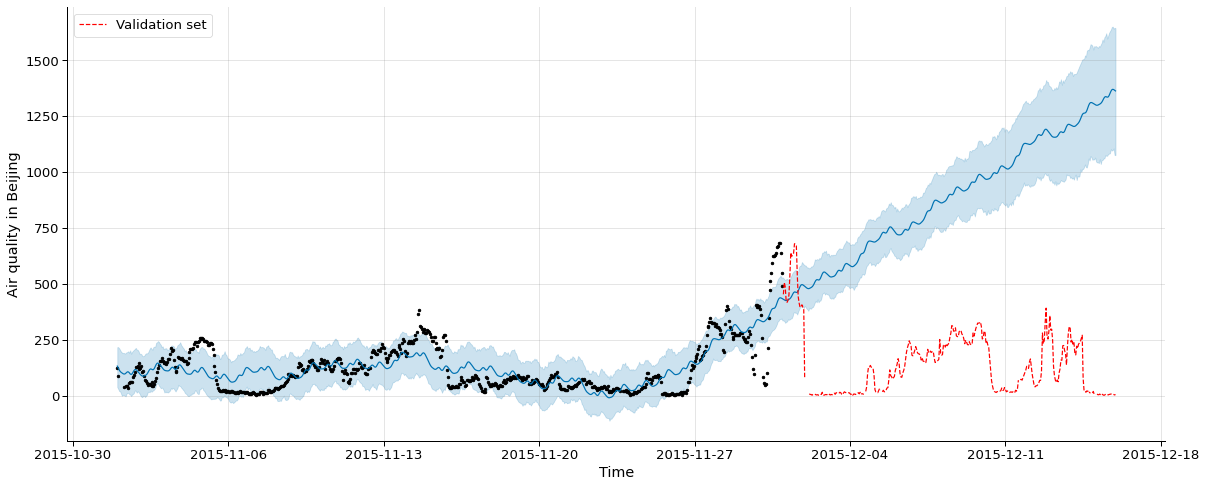

In [28]:
m.plot(forecast, figsize= (17,7), xlabel= "Time", ylabel= "Air quality in Beijing")
plt.plot(df_test.y, 'r--', label= "Validation set")
plt.legend(loc= 'upper left')
plt.show()

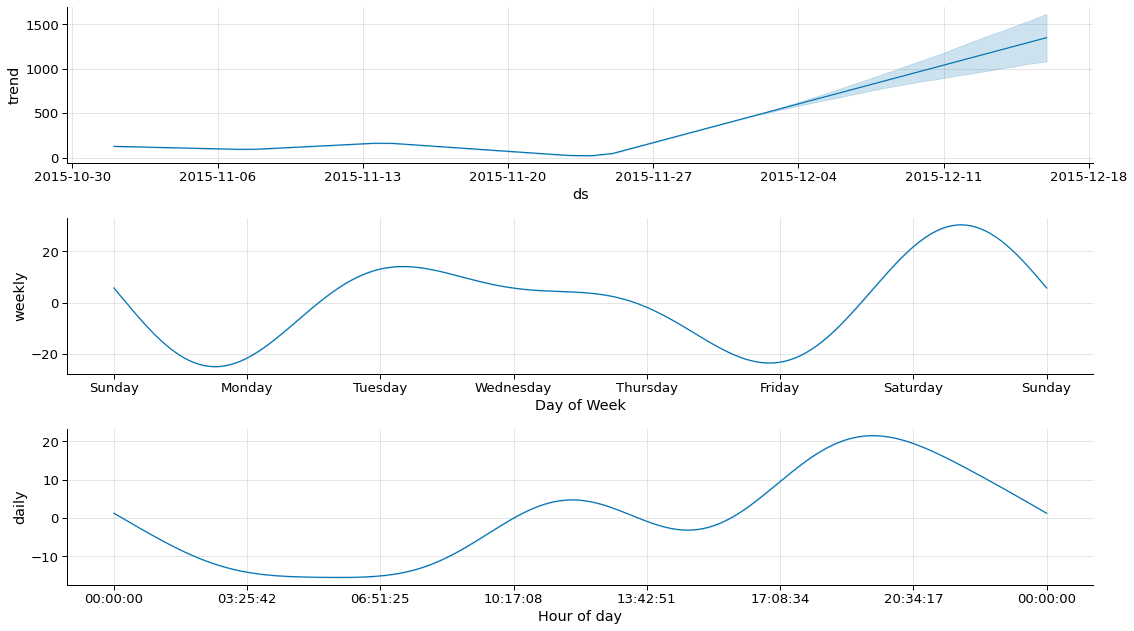

In [29]:
forecase_components= m.plot_components(forecast, figsize= (16,9))

We observe the trend is very strong, so we need to change that

In [ ]:
# Decreasted drastically from defaults
changepoint_prior_scale = 0.0005 # Default => 0.05
seasonality_prior_scale = 10.0

m= Prophet(seasonality_prior_scale= seasonality_prior_scale, changepoint_prior_scale= changepoint_prior_scale)
m.fit(df_train)
forecast= m.predict(future)

In [ ]:
# df_cv= cross_validation(m, horizon= '365 days', period= '180 days', initial= '730 days')
df_cv= cross_validation(m, horizon= 15*24, period= '60 hours')

In [49]:
print("CV shape: {}, Number of cutoffs: {}".format(df_cv.shape, len(df_cv.cutoff.unique())))
metrics= performance_metrics(df_cv)
metrics
# display(metrics[['horizon', 'rmse', 'mape']])
# print("Mean-RMSE: {:.4f} and Mean-MAPE: {:.2%}".format(np.mean(metrics['rmse']), np.mean(metrics['mape'])))
# print("Horizon of 365 days RMSE: {:.4f} and MAPE: {:.2%}".format(metrics.iloc[metrics.shape[0]-1]['rmse'], metrics.iloc[metrics.shape[0]-1]['mape']))

CV shape: (10, 6), Number of cutoffs: 10


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 00:00:00.000000360,23088.346756,151.9485,120.922117,2.139098,0.730332,0.968662,0.6


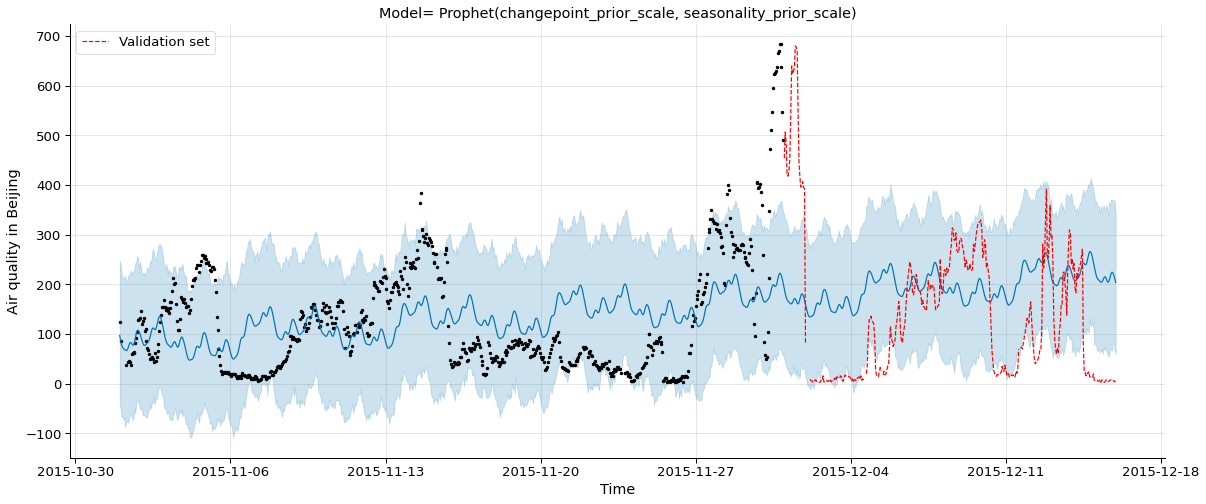

In [42]:
image_dir= '../../../plots/time_series_analysis/'
plot_name= 'prophet.tunning.parameters.png'

# Plotting:
forecast_plot= m.plot(forecast, figsize= (17,7), xlabel= "Time", ylabel= "Air quality in Beijing")
ax = forecast_plot.gca()
ax.set_title("Model= Prophet(changepoint_prior_scale, seasonality_prior_scale)")
plt.plot(df_test.y, 'r--', label= "Validation set")
plt.legend(loc= 'upper left')
plt.show()

forecast_plot.savefig(image_dir+plot_name)

We observe auto-correlation on the validation set.  
**Prophet** does not do a great job of picking **auto-correlation** bc it's not additive model. Does not incorporate the relationship with past values

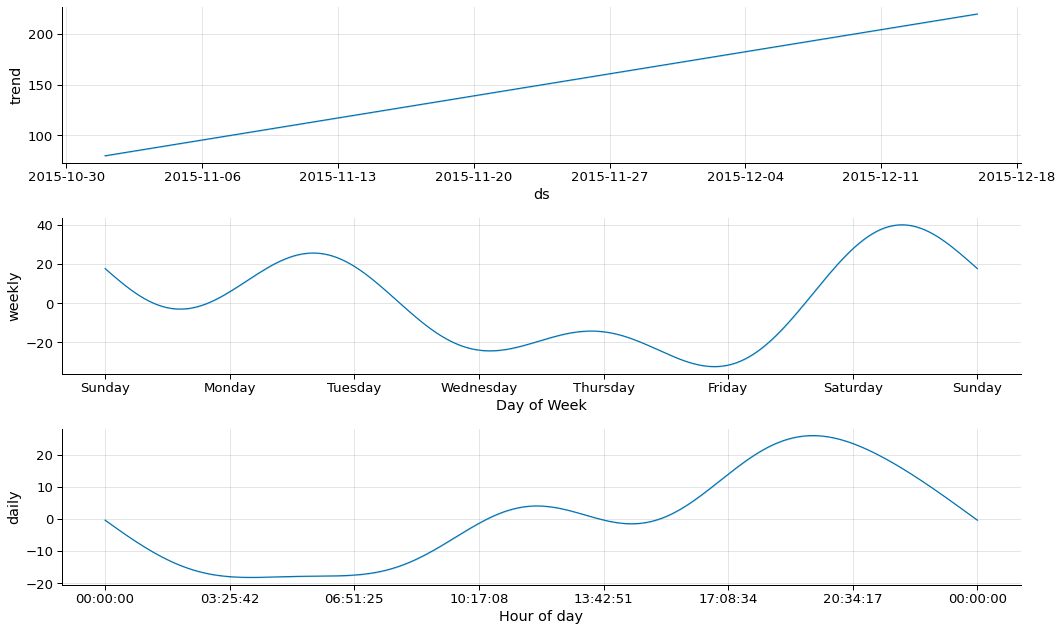

In [34]:
forecast_components= m.plot_components(forecast, figsize= (15,9))

## Cross-validation

In [ ]:
# future = m.make_future_dataframe(periods = 15*24,freq = 'h')
# df_cv= cross_validation(m, horizon= '365 days', period= '180 days', initial= '730 days')
df_cv= cross_validation(m, horizon= 15*24, period= '60 hours')

In [38]:
display(df_cv)
metrics= performance_metrics(df_cv)
metrics[['rmse', 'mape']].round(4)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-11-08 11:00:00,16.500038,-21.449691,53.550724,46.0,2015-11-08 10:59:59.999999640
1,2015-11-10 23:00:00,192.535424,153.808090,229.916677,168.0,2015-11-10 22:59:59.999999640
2,2015-11-13 11:00:00,52.295381,-7.773343,120.210607,204.0,2015-11-13 10:59:59.999999640
3,2015-11-15 23:00:00,198.716023,106.720091,293.440005,39.0,2015-11-15 22:59:59.999999640
4,2015-11-18 11:00:00,155.546776,46.572006,262.076727,58.0,2015-11-18 10:59:59.999999640
5,2015-11-20 23:00:00,117.539253,14.405083,216.676632,34.0,2015-11-20 22:59:59.999999640
6,2015-11-23 11:00:00,56.661454,-40.683090,152.740326,33.0,2015-11-23 10:59:59.999999640
7,2015-11-25 23:00:00,85.084885,-9.424581,168.098044,8.0,2015-11-25 22:59:59.999999640
8,2015-11-28 11:00:00,121.955682,12.139505,220.571674,401.0,2015-11-28 10:59:59.999999640
9,2015-11-30 23:00:00,207.111546,63.845704,350.939085,490.0,2015-11-30 22:59:59.999999640


,rmse,mape
0,151.9485,2.1391


In [51]:
import session_info
session_info.show()